In [15]:
!git clone https://github.com/Rope-player/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 548 (delta 5), reused 162 (delta 0), pack-reused 374
Receiving objects: 100% (548/548), 50.13 MiB | 30.76 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [16]:
%cd "pytorch_advanced"

/content/pytorch_advanced


In [17]:
%cd "2_objectdetection"

/content/pytorch_advanced/2_objectdetection


In [18]:
%ls

2-2-3_Dataset_DataLoader.ipynb    2-8_SSD_inference.ipynb
2-4-5_SSD_model_forward.ipynb     data/
2-6_loss_function.ipynb           make_folders_and_data_downloads.ipynb
2-7_SSD_training.ipynb            utils/
2-8_SSD_inference_appendix.ipynb


In [19]:
import os
import urllib.request
import zipfile
import tarfile

In [21]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [22]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [23]:
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)
    tar.close()

In [24]:
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [25]:
url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [26]:
import os.path as osp
import random

import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [28]:
%ls

2-2-3_Dataset_DataLoader.ipynb  2-8_SSD_inference_appendix.ipynb       utils/
2-4-5_SSD_model_forward.ipynb   2-8_SSD_inference.ipynb                weights/
2-6_loss_function.ipynb         data/
2-7_SSD_training.ipynb          make_folders_and_data_downloads.ipynb


# SSD 데이터셋 구현

## 화상 데이터, 어노테이션 데이터 파일 경로 리스트 작성

물체 감지와 화상 분류 데이터셋의 가장큰 차이점은 ***어노테이션***. 화상분류에서는 파일 및 폴더 이름에 클래스명이 포함되어있고 해답 데이터(어노테이션 데이터)는 없음.

물체 감지에서 물체 위치와 라벨의 해답이 되는 어노테이션은 바운딩 박스의 정보이며 어노테이션 데이터로 제공됨. 즉, **물체 감지는 화상 데이터와 어노테이션 데이터를 함꼐 데이터셋에서 처리해야 함.**

먼저, 화상데이터와 어노베이션 데이터의 경로를 리스트형 변수로 작성. 훈련 및 검증용으로 총 4개 작성.

`train.txt`와 `val.txt`를 읽어들여 훈련 및 검증의 각 파일 ID를 받은 후 화상과 어노테이션 파일의 경로 리스트 작성


In [29]:
def make_datapath_list(rootpath):
  # 데이터 경로를 저장한 리스트 작성

  # Parameters 
  #   rootpath : str - 데이터폴더 경로
  #
  # Returns
  #   ret :  train_img_list, train_anno_list, val_img_list, val_anno_list - 데이터 경로를 저장한 리스트

  # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
  imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
  annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

  # 훈련 및 검증 파일 ID(파일 이름) 취득
  train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
  val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

  # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
  train_img_list = list()
  train_anno_list = list()

  for line in open(train_id_names):
    file_id = line.strip()                     # 공백과 줄바꿈 제거
    img_path = (imgpath_template % file_id)    # 화상 경로
    anno_path = (annopath_template % file_id)  # 어노테이션 경로
    train_img_list.append(img_path)            # 학습 데이터 리스트에 추가
    train_anno_list.append(anno_path)          # 어노테이션 파일 리스트에 추가

  
  # 검증 데이터의 화상파일과 어노테이션 파일의 경로 리스트 작성
  val_img_list = list()
  val_anno_list = list()

  for line in open(val_id_names):
    file_id = line.strip()                     # 공백과 줄바꿈 제거
    img_path = (imgpath_template % file_id)    # 화상 경로
    anno_path = (annopath_template % file_id)  # 어노테이션 경로
    val_img_list.append(img_path)              # 검증 데이터 리스트에 추가
    val_anno_list.append(anno_path)            # 어노테이션 파일 리스트에 추가


  return train_img_list, train_anno_list, val_img_list, val_anno_list

In [30]:
# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 동작 확인
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


## XML 형식의 어노테이션 데이터를 리스트로 변환

어노테이션 데이터는 xml 형식의 데이터.xml 데이터를 파이썬 리스트형 변수로 변환하는 `Anno_xml2list` 클래스 작성.

`__call__` 을 메소드(대상 화상의 폭과 높이를 린수로 사용하여 바운딩 박스(BBox)의 좌표를 규격화함)로 구성하고 클래스명과 동일한 이름의 변환 함수 실행.

어노테이션 데이터는 물체의 이름이 클래스명의 문자열로 되어있고 순자로 변경해야 함. `Anno_xml2list` 클래스의 인스턴스를 생성할 때 생성자의 인수에 VOC 데이터셋 클래스명 스무개를 배치한 리스트 classes를 할당하고 클래스명을 인덱스 `label_idx = self.classes.index(name)`로 바꿈.


In [31]:
# xml 형식의 어노태이션을 리스트로 변환하는 클래스

class Anno_xml2list(object):
  # 한 화상의 xml 형식 어노테아션을 화상크기로 규격화 해 리스트로 변환
  # Attributes 
  #   classes : 리스트 - VOC의 클래스명을 저장한 리스트

  def __init__(self, classes):
    self.classes = classes

  def __call__(self, xml_path, width, height):
    # 화상의 xml 어노테이션을 화상 크기로 규격화하여 리스트로 변환
    # Parameters
    #   xml_path : str - xml 파일 경로
    #   width    : int - 대상 화상 폭 
    #   height   : int - 대상 화상 높이
    #
    # Returns
  
    # 화상 내 모든 물체의 어노테이션을 저장하는 리스트
    ret = []

    # xml 파일 로드
    xml = ET.parse(xml_path).getroot()

    # 화상 내 물체 수만큼 반복
    for obj in xml.iter('object'):
      difficult = int(obj.find('difficult').text)  # 어노테이션 검지가 difficult로 설정돤 것은 제외
      if difficult == 1:
        continue

      bndbox = []  # 한 물체의 어노테이션을 저장하는 리스트

      name = obj.find('name').text.lower().strip()  # 물체 이름
      bbox = obj.find('bndbox')                     # BBox 정보

      # 어노테이션의 'xmin', 'ymin', 'xmax', 'ymax'를 취득하고 0 ~ 1로 규격화
      pts = ['xmin', 'ymin', 'xmax', 'ymax']

      for pt in (pts):
        cur_pixel = int(bbox.find(pt).text) - 1 # VOC는 원점이 (1, 1)이므로 1을 빼서 (0, 0)으로 만들어줌

        # 폭, 높이로 규격화
        if pt == 'xmin' or pt == 'xmax':  # x방향은 폭으로 나눔
          cur_pixel /= width
        else:                             # y방향은 높이로 나눔
          cur_pixel /= height

          bndbox.append(cur_pixel)

        # 어토네이션의 클래스명을 index를 취득하여 추가
        label_idx = self.classes.index(name)
        bndbox.append(label_idx)
     
        # re에 ['xmin', 'ymin', 'xmax', 'ymax', label_idx]를 더함.
        ret += [bndbox]

      return np.array(ret)

In [32]:
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용 OpenCV

ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[18.        ,  0.03003003, 18.        , 18.        ,  0.996997  ,
        18.        ],
       [18.        ,  0.03003003, 18.        , 18.        ,  0.996997  ,
        18.        ],
       [18.        ,  0.03003003, 18.        , 18.        ,  0.996997  ,
        18.        ],
       [18.        ,  0.03003003, 18.        , 18.        ,  0.996997  ,
        18.        ]])

## 화상과 어노테이션의 전처리를 실시하는 DataTransform 클래스 작성

화상분류와 다르게 화상을 변형시킬때 BBox 정보도 함께 변경해야 함.

훈련시의 데이터 확장에서 색조를 변환하고 화상 크기를 변경하여 임의로 자르는 작업을 수행. 또한 화상의 크기를 리사이즈 하고 색상으 평균 정보값을 뻄. 추론 시에는 화상의 크기를 변환하고 색상의 평균값을 빼기만 하면 됨.

화상데이터를 불러올 때는 OpenCV를 사용. ([높이], [폭], [BGR] 순으로 불러옴) 특히 색이 `RGB`가 아닌 `BGR`임에 유의.

In [33]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
  # 화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
  # 화상의 크기는 300 * 300
  # 학습시 데이터 확장 수행
  #
  # Attributes
  #   int_size   : int - 릿이즈 대상의 화상 크기
  #   color_mean : (B, G, R) - 각 생상 채널의 평균 값

  def __init__(self, input_size, color_mean):
    self.data_transform = {
      'train': Compose([
        ConvertFromInts(),         # int를 float32로 변환
        ToAbsoluteCoords(),        # 어노테이션의 규격화 반환
         PhotometricDistort(),     # 화상의 색조 등 임의로 변화
        Expand(color_mean),        # 캔버스 확대
        RandomSampleCrop(),        # 화상 내 특정 부분 무작위 추출
        RandomMirror(),            # 화상 반전
        ToPercentCoords(),         # 어노테이션 크기를 0 ~ 1로 규격화
        Resize(input_size),        # 화상 크기를 input_size×input_size로 변형
        SubtractMeans(color_mean)  # BGR 색상의 평균 값 빼기
      ]),
      'val': Compose([
        ConvertFromInts(),         # int를 float로 변환
        Resize(input_size),        # 화상 크기를 input_size×input_size로 변형
         SubtractMeans(color_mean) # BGR 색상의 평균 값 빼기
      ])
    }


  def __call__(self, img, phase, boxes, labels):
    # Parameters
    #   phase : 'train' or 'val' - 전처리 모드 지정

    return self.data_transform[phase](img, boxes, labels)

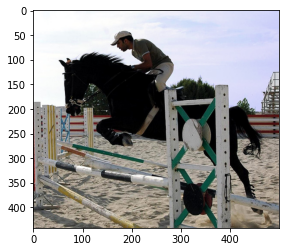

/content/pytorch_advanced/2_objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


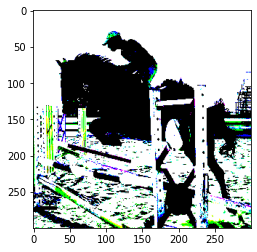

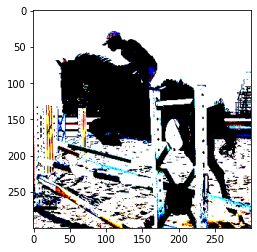

In [34]:
# 동작 확인

# 1. 화상 읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

# 2. 어노테이션을 리스트화
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

# 5. train 화상 표시
phase = "train"
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val 화상 표시
phase = "val"
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

## 데이터셋 작성

파이토치의 Dataset 클래스를 상속받아 `VOCDataset` 클래스를 작성. `Anno_xml2list`, `DataTransform` 클래스를 활용.

`__getitem__()` 함수를 정의하고 전처리한 화상데이터와 어노테이션을 획득.

In [35]:
class VOCDataset(data.Dataset):
  # Attributes
  #   img_list : 리스트        - 화상경로를 지정하는 리스트
  #   anno_list : 리스트       - 어노테이션 경로를 지정한 리스트
  #   phase : 'train' or 'val' - 학습이나 훈련 결정
  #   transform : object       - 저처리 클래스의 인스턴스
  #   transform_anno : object  - xml 어노테이션을 리스트로 변환하는 인스턴스



  def __init__(self, img_list, anno_list, phase, transform, transform_anno):
    self.img_list = img_list
    self.anno_list = anno_list 
    self.phase = phase                   # train 혹은 val 지정.
    self.transform = transform           # 화상변형
    self.transform_anno = transform_anno # 어노테이션을 xml 에서 list로 변경


  def __len__(self):  # 전처리한 화상의 매수 반환
    return len(self.img_list)

  def __getitem__(self, index): # 전처리한 화상의 텐서형식 데이터와 어노테이션 취득
    im, gt, h, w = self.pull_item(index)
    return im, gt

  def pull_item(self, index):   # 전처리한 화상의 정보 취득
    # 1. 화상 읽기
    image_file_path = self.img_list[index]
    img = cv2.imread(image_file_path)
    height, width, channels = img.shape

    # 2. xml 어노테이션 정보를 리스트에 저장
    anno_file_path = self.anno_list[index]
    anno_list = self.transform_anno(anno_file_path, width, height)
    
    # 3. 전처리 실시
    img, boxes, labels = self.transform(
    img, self.phase, anno_list[:, :4], anno_list[:, 4])

    # 색상 채널 순서를 BGR -> RGB로 변경
    # (높이, 폭, 색상) 순서를 (색상, 높이, 폭)으로 변경
    img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # BBox와 라벨을 세트로 한 np.array 작성. 변수 이름 gt는 ground truth의 약칭
    gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

    return img, gt, height, width

In [36]:
# 동작 확인
color_mean = (104, 117, 123)  # (BGR)의 평균값
input_size = 300              # 화상 크기를 300 * 300으로 설정

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

## 데이터로더 구현

SSD 학습 및 추론시 데이터를 미니배치로 꺼내기위한 DataLoader 클래스 구현.

물체 감지에서는,
- 화상데이터마다 Dataset에서 꺼낼 어노테이션 정보, gt 변수 크기(화상내 물체의 수)가 다름. 
- gt는 리스트형 변수이고 요소 수는 화상 속 물체 수.
- 각 요소는 다섯 개의 변수, `['xmin', 'ymin', 'xmax', 'ymax', label_idx]`

DataLoader 클래스에서 기본적으로 사용하는 데이터 추출함수인 collate_fn을 별도로 만들어야 함. 또한 `od`는 Object Detection의 약칭임.

In [37]:
def od_collate_fn(batch):
  # 데이터셋에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다르다.
  # 화상 내 물체가 두 개면 (2, 5)사이즈 이지만, 세 개면 (3, 5)이다. 
  # 이러한 변화에 다응하는 것이 fn_collate 이다.
  # fn_collate는 파이토치 리스트로 mini-batch를 작성하는 함수.
  # 미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 
  # 차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.

  targets = []
  imgs = []
  for sample in batch:
    imgs.append(sample[0])                       # sample[0]은 화상 img
    targets.append(torch.FloatTensor(sample[1])) # sample[1]은 어노테이션gt

  # imgs는 미니 배치 크기의 리스트
  # 리스트 요소는 torch.size([3, 300, 300])
  # 이 리스트를 torch.size([batch_num, 3, 300, 300])의 텐서로 변환 
  imgs = torch.stack(imgs, dim=0)

  # targets은 어노테이션의 정답인 gt 리스트
  # 리스트 크기 = 미니 배치 크기
  # targets 리시트 요소는 [n, 5], 'n'은 화상속 물체 수, 5는 ['xmin', 'ymin', 'xmax', 'ymax', label_idx]
  return imgs, targets

In [38]:
# 데이터 로더
batch_size = 4

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
images, targets = next(batch_iterator)          # 첫 번째 요소 추출
print(images.size())                            # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())

torch.Size([4, 3, 300, 300])
4
torch.Size([4, 5])


마지막으로 데이터의 수 확인

In [39]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823
